In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

In [72]:
df_plb = pd.read_csv("datasets/planetlab.txt", sep=" ", header=None, names=["name", "x", "y"])
df_plb["type"] = "worker"
tcolors = {"coordinator": "red", "worker": "grey"}
eval_matrix = {}
X_dim = [-50, 70]
Y_dim = [-140, 180]

In [73]:
df_plb

,name,x,y,type
0,planet1.cs.ucsb.edu,34.4285,-119.7220,worker
1,planet1.scs.cs.nyu.edu,40.7292,-73.9934,worker
2,planet2.scs.cs.nyu.edu,40.7292,-73.9934,worker
3,planet1.scs.stanford.edu,37.4294,-122.1720,worker
4,ricepl-1.cs.rice.edu,29.7225,-95.3924,worker
...,...,...,...,...
464,pl2.planetlab.ics.tut.ac.jp,34.7008,137.4100,worker
465,saturn.cs.brown.edu,41.8200,-71.4200,worker
466,jupiter.cs.brown.edu,41.8200,-71.4200,worker
467,pluto.cs.brown.edu,41.8200,-71.4200,worker


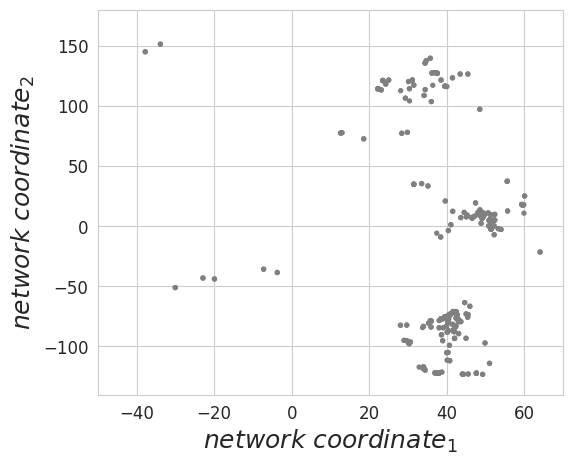

In [74]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

scat2 = df_plb.plot.scatter(ax=ax1, x="x", y="y", c=df_plb["type"].map(tcolors), s=8)

#plot coordinators
#ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

#ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$', fontsize=18)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=18)
plt.savefig("plots/planetlab/planetlab_ncs_plain.svg", bbox_inches = "tight")
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.show()

In [75]:
coords = df_plb[["x", "y"]].to_numpy()

## PlanetLab

In [76]:
def label_to_str(label):
    if label == 0:
        return "US West"
    elif label == 1:
        return "US East"
    else:
        return "Europe"

5
10
[0.6544951049178493, 0.7609503305328206, 0.7228235997299712, 0.6790517020352376, 0.6992999595892874, 0.7415500336409566, 0.6352800464052314, 0.6346137701333803, 0.6077857768848263]
Optimal k is  3


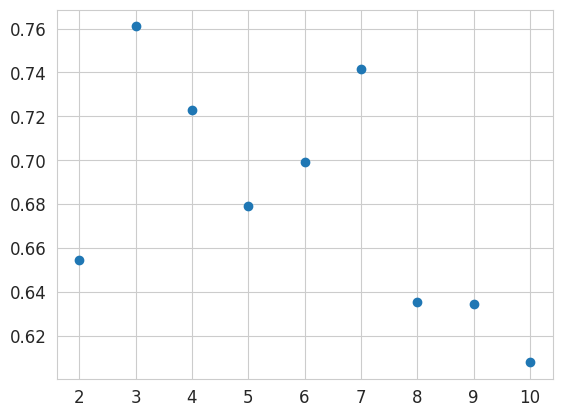

In [77]:
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 10  #centers + 5
kseed = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(kmin, kmax + 1):
    if k % 5 == 0:
        print(k)
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
    labels = kmeans.labels_
    sil.append(silhouette_score(coords, labels, metric='euclidean'))

print(sil)

opt_k = np.argmax(sil)
opt_k = kmin + opt_k
print("Optimal k is ", opt_k)

cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
labels = cluster_alg.labels_
centroids = cluster_alg.cluster_centers_
plt.scatter(x=list(range(kmin, kmax + 1)), y=sil)
df = pd.DataFrame(coords, columns=["x", "y"])
df["cluster"] = labels
df["label"] = df["cluster"].apply(lambda x: label_to_str(x))

In [78]:
df

,x,y,cluster,label
0,34.4285,-119.7220,0,US West
1,40.7292,-73.9934,0,US West
2,40.7292,-73.9934,0,US West
3,37.4294,-122.1720,0,US West
4,29.7225,-95.3924,0,US West
...,...,...,...,...
464,34.7008,137.4100,1,US East
465,41.8200,-71.4200,0,US West
466,41.8200,-71.4200,0,US West
467,41.8200,-71.4200,0,US West


In [79]:
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

color_list = sns.color_palette(n_colors=no_clusters)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
color_list

Estimated no. of clusters: 3
Estimated no. of noise points: 0


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

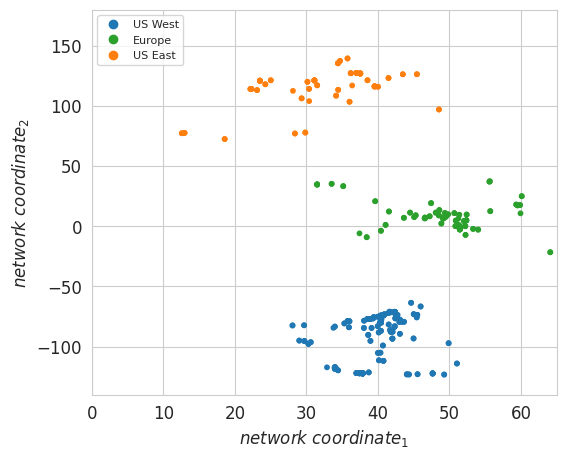

In [80]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
# super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')
# super_plot.scatter(centroids[:, 0], centroids[:, 1], s=100, marker="o", color=colors)

us_west_label = Line2D([], [], color=colors[0], marker="o", linestyle='None', label='US West')
europe_label = Line2D([], [], color=colors[2], marker="o", linestyle='None', label='Europe')
us_east_label = Line2D([], [], color=colors[1], marker="o", linestyle='None', label='US East')

plt.legend(handles=[us_west_label, europe_label, us_east_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
# plt.title('PlanetLab Topology (k=' + str(no_clusters) + ")")
plt.xlim([0, 65])
plt.ylim(Y_dim)
plt.savefig("plots/planetlab/planetlab_ncs.svg", bbox_inches = "tight")
plt.show()

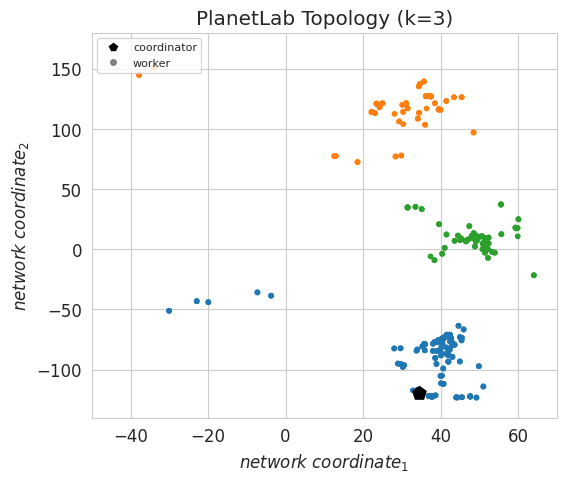

In [81]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
# super_plot.scatter(centroids[:, 0], centroids[:, 1], s=100, marker="o", color=colors)
super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

us_west_label = Line2D([], [], color=colors[0], marker="o", linestyle='None', label='US West')
europe_label = Line2D([], [], color=colors[2], marker="o", linestyle='None', label='Europe')
us_east_label = Line2D([], [], color=colors[1], marker="o", linestyle='None', label='US East')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/planetlab/planetlab_" + str(no_clusters) + ".svg", bbox_inches = "tight")
plt.title('PlanetLab Topology (k=' + str(no_clusters) + ")")
plt.show()

## Capacity Config

Std:  44.64025600464227


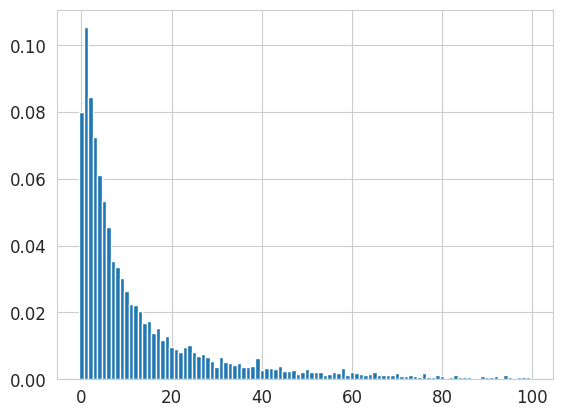

In [82]:
mode = 1
stddev = 50
sigma, scale = util.lognorm_params(mode, stddev)
sample = lognorm.rvs(sigma, 0, scale, size=10000).astype(int)

print("Std: ", np.std(sample))

H, bins = np.histogram(sample, bins=100, range=[0, 100], density=True)
plt.bar(bins[:-1],H,width=1)
plt.show()

In [83]:
capacity_columns = []
np.random.seed(4)
avg = 50
c_coords = coords[0]
device_number = len(df_plb)
max_resources = device_number*avg - 100
type_list = ["worker" for x in range(device_number - 1)]
type_list.insert(0, "coordinator")

df['latency'] = list(zip(df.x, df.y))
df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - c_coords))
df["type"] = pd.Series(type_list, dtype="category")
df.loc[0, "cluster"] = -1

sums = []
for i in range(len(H), 0, -1):
    if (i % 10 == 0) or (i == 5) or (i == 1):
        #probabilites
        p = np.array(H[i-1:len(H)])
        p /= p.sum()  # normalize
        pop = np.arange(i-1, len(H))

        capacity_list = np.random.choice(pop, len(df)-1, p=p, replace=True)
        capacity_list =np.insert(capacity_list, 0, 0)

        col = "capacity_"+str(i)
        df[col] = pd.Series(capacity_list, dtype="int")
        df["capacity_"+str(i)] = df[col] / df[col].sum() * max_resources

        df[col] = np.ceil(df[col]).astype("int")
        df.at[0, col] = 100
        sums.append((df[col].sum()))
        capacity_columns.append(col)

print(sums)
prim_df = df.copy()

[23500, 23705, 23690, 23690, 23663, 23676, 23686, 23717, 23684, 23692, 23671, 23649]


In [84]:
prim_df

,x,y,cluster,label,latency,type,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,34.4285,-119.7220,-1,US West,0.000000,coordinator,100,100,100,100,100,100,100,100,100,100,100,100
1,40.7292,-73.9934,0,US West,46.160629,worker,50,50,55,45,46,37,54,43,25,33,10,15
2,40.7292,-73.9934,0,US West,46.160629,worker,50,51,48,59,52,54,39,31,30,143,67,64
3,37.4294,-122.1720,0,US West,3.874003,worker,50,49,54,44,42,39,54,82,81,45,23,4
4,29.7225,-95.3924,0,US West,24.780554,worker,50,49,52,55,54,42,42,72,44,166,10,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,34.7008,137.4100,1,US East,257.132144,worker,50,50,55,55,57,43,41,57,25,18,33,67
465,41.8200,-71.4200,0,US West,48.864276,worker,50,48,51,48,51,64,55,43,29,43,18,19
466,41.8200,-71.4200,0,US West,48.864276,worker,50,51,56,47,44,48,78,39,33,25,15,4
467,41.8200,-71.4200,0,US West,48.864276,worker,50,52,52,47,56,53,36,31,26,113,52,12


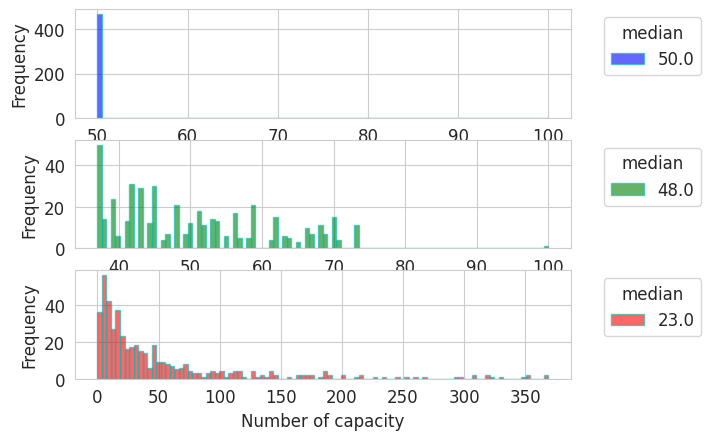

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

i=100
df["capacity_"+str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c', label=df["capacity_"+str(i)].median())

i=50
df["capacity_"+str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c', label=df["capacity_"+str(i)].median())

i=1
df["capacity_"+str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c', label=df["capacity_"+str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')

ax3.set_xlabel("Number of capacity")

plt.show()

Medians from  50  to  20


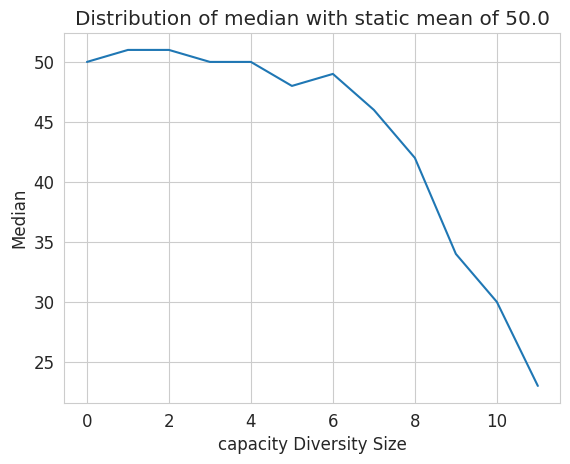

In [86]:
medians = []
mean = np.floor(prim_df["capacity_"+str(1)].mean())

for col in capacity_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = str(int(medians[0] - medians[0] % 5))
last_med_label = str(int(medians[-1] - medians[-1] % 5))
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("capacity Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator

In [87]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["dt"] = df_stats.copy()

### Experiment 2: LEACH Protocol

In [88]:
seed = 20
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(device_number*0.1)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  46
[464, 371, 352, 403, 393, 451, 78, 134, 346, 326, 435, 52, 447, 168, 294, 87, 14, 211, 209, 39, 53, 65, 164, 243, 298, 231, 107, 103, 163, 321, 466, 349, 172, 169, 219, 48, 322, 266, 413, 431, 252, 208, 42, 106, 125, 18]


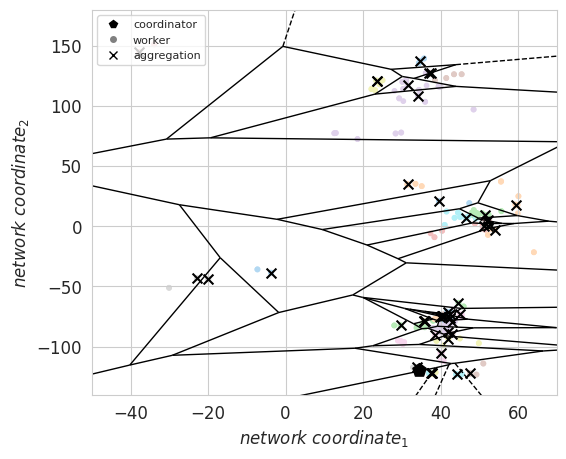

In [89]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, aggp_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/planetlab/leach.svg")
plt.show()

In [90]:
statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["leach"] = df_stats.copy()

### Experiment 3: NEMO Aggregation with Density-based Grouping

In [91]:
prim_df

,x,y,cluster,label,latency,type,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,34.4285,-119.7220,-1,US West,0.000000,coordinator,100,100,100,100,100,100,100,100,100,100,100,100
1,40.7292,-73.9934,0,US West,46.160629,worker,50,50,55,45,46,37,54,43,25,33,10,15
2,40.7292,-73.9934,0,US West,46.160629,worker,50,51,48,59,52,54,39,31,30,143,67,64
3,37.4294,-122.1720,0,US West,3.874003,worker,50,49,54,44,42,39,54,82,81,45,23,4
4,29.7225,-95.3924,0,US West,24.780554,worker,50,49,52,55,54,42,42,72,44,166,10,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,34.7008,137.4100,1,US East,257.132144,worker,50,50,55,55,57,43,41,57,25,18,33,67
465,41.8200,-71.4200,0,US West,48.864276,worker,50,48,51,48,51,64,55,43,29,43,18,19
466,41.8200,-71.4200,0,US West,48.864276,worker,50,51,56,47,44,48,78,39,33,25,15,4
467,41.8200,-71.4200,0,US West,48.864276,worker,50,52,52,47,56,53,36,31,26,113,52,12


In [92]:
# assign nodes to previous clustering alg
iterations = 100
W = 80
L = 100

capacity_col = "capacity_100"
med_label = first_med_label
eval_name = "nemo_dc"
eval_matrix[eval_name], new_paths_flat, agg_dict_flat, df_dict_flat = evaluate_nemo(prim_df, coords, W, L, False, capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


In [93]:
reassigned_clussters = util.get_diff(agg_dict_flat["base"], agg_dict_flat[capacity_col])
print(reassigned_clussters)

[0, 1, 2]


In [94]:
#Test to see if there are any overloaded nodes, result should be empty
df_overloaded = df_dict_flat[capacity_col].groupby(['parent']).size()
df_capacity = df_dict_flat[capacity_col][capacity_col][df_overloaded.index]
result = pd.concat([df_capacity, df_overloaded], axis=1).reindex(df_overloaded.index)
result.columns = ["capacity", "count"]
result["load"] = result["capacity"] - result["count"]
result[result["load"] < 0]

,capacity,count,load
parent,,,


In [95]:
centroids

array([[ 37.60855939, -90.44811034],
       [ 29.03624255, 116.60493617],
       [ 48.75688947,   9.00766667]])

In [96]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

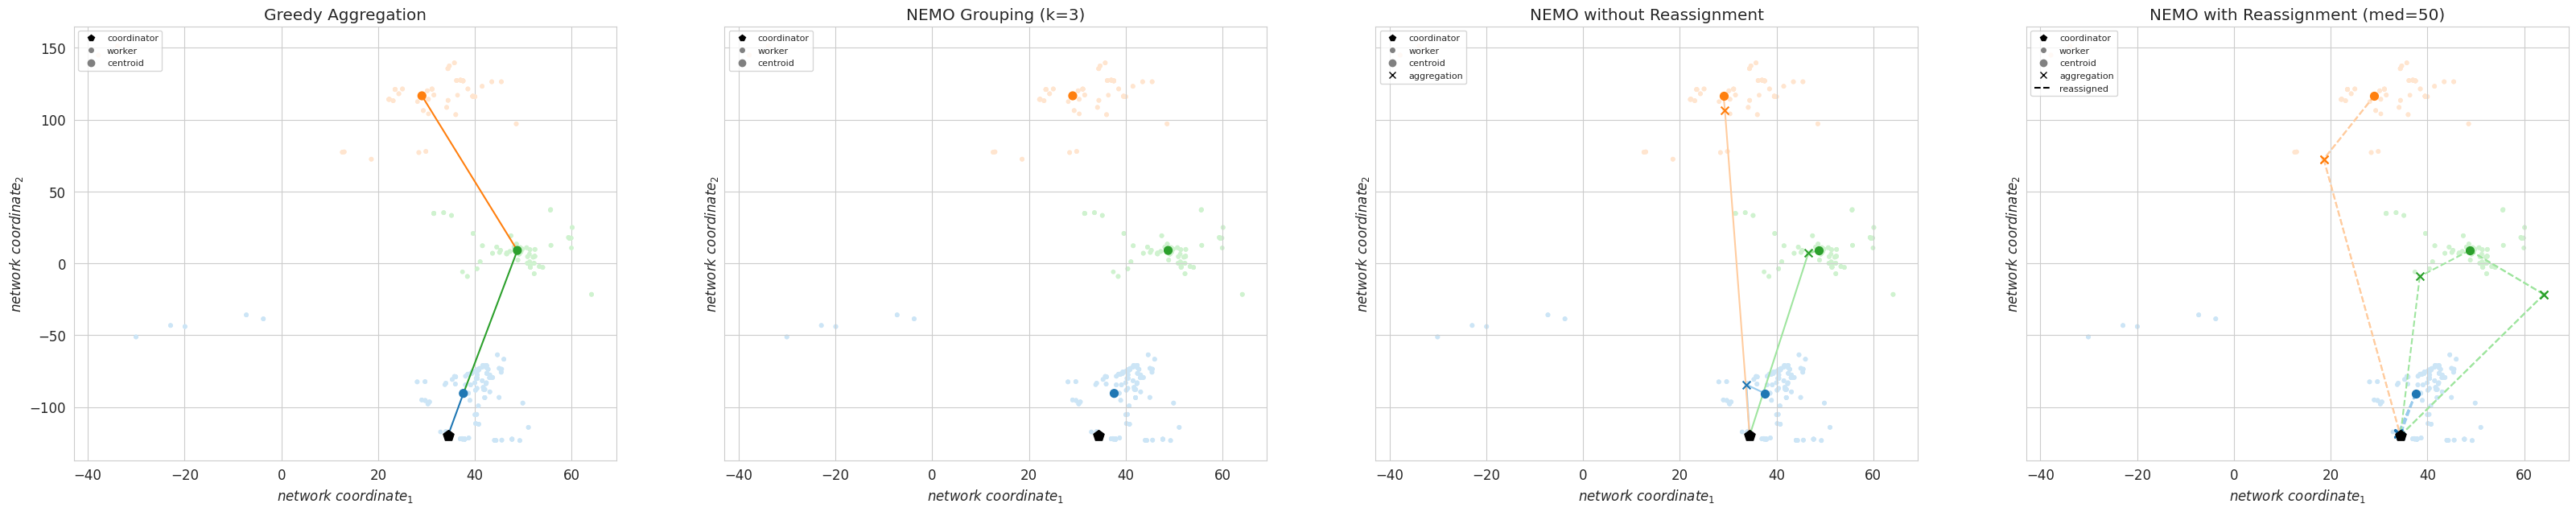

In [97]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.2

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i-1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)

ax2.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax2.set_title('NEMO Grouping (k=' + str(opt_k) + ")")
ax2.set_xlabel('$network$ $coordinate_1$')
ax2.set_ylabel('$network$ $coordinate_2$')

#plot our solutions
util.plot(ax3, new_paths_flat["base"], agg_dict_flat["base"], c_coords, cluster_coords, coords, colors, labels, lval=lval)
util.plot(ax4, new_paths_flat[capacity_col], agg_dict_flat[capacity_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("NEMO without Reassignment")
ax4.set_title("NEMO with Reassignment (med=" + med_label + ")")

plt.savefig("plots/planetlab/nemo_phases_planetlab.svg",  bbox_inches="tight")

# Save just the portion _inside_ the second axis's boundaries
names = ["greedy.svg", "nemo_grouping.svg", "nemo_plcmt.svg", "nemo_reassignment.svg"]
axes = [ax1, ax2, ax3, ax4]
#for i in range(0, 4):
#    extent = util.full_extent(axes[i]).transformed(fig.dpi_scale_trans.inverted())
#    fig.savefig("plots/planetlab/" + names[i], bbox_inches="tight")

plt.show()

### Experiment 3b: NEMO Aggregation with Random Grouping

In [98]:
np.random.seed(10)
random_labels = np.random.randint(0, no_clusters, df.shape[0])
random_labels[0] = -1
iterations = 100
W = 80
L = 100
df = prim_df.copy()
df["cluster"] = random_labels

In [99]:
eval_name = "nemo_rc"
eval_matrix[eval_name], new_paths_rdm, agg_dict_rdm, df_dict_rdm = evaluate_nemo(df, coords, W, L, False,
                                                                                 capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


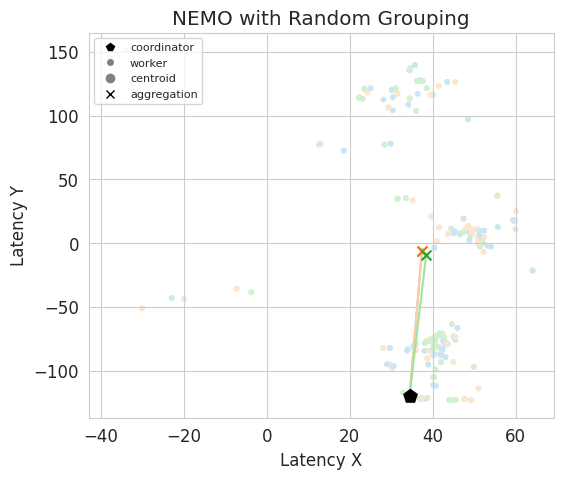

In [100]:
fig = plt.figure(figsize=(6, 5))
lval = 0.2

f1 = fig.add_subplot(111)
random_labels[0] = 0
util.plot(f1, new_paths_rdm["base"], agg_dict_rdm["base"], c_coords, None, coords, colors, random_labels, lval=lval,
          print_centroids=False)

plt.xlabel('Latency X')
plt.ylabel('Latency Y')
plt.title('NEMO with Random Grouping')

plt.show()

Distribution of workload:  0.4264 %


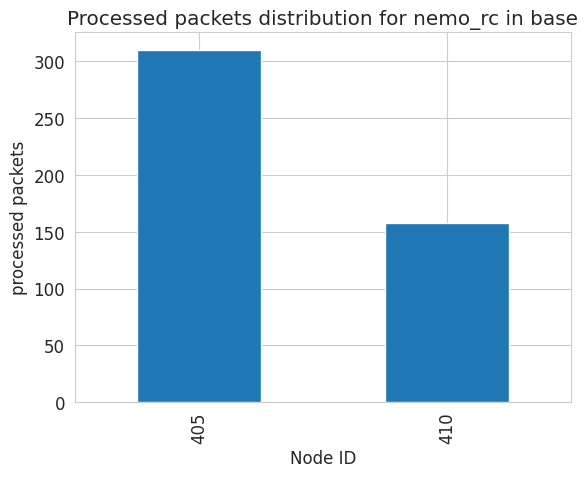

In [101]:
eval_col = list(eval_matrix[eval_name])[0]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [102]:
mst = prim_mst(coords)

In [103]:
print(mst)

[-1, 195, 1, 95, 108, 56, 5, 258, 28, 8, 212, 90, 11, 343, 13, 10, 369, 16, 330, 18, 7, 219, 21, 21, 260, 24, 24, 0, 79, 28, 28, 208, 31, 441, 24, 34, 34, 433, 37, 3, 198, 40, 40, 465, 43, 43, 108, 360, 47, 47, 415, 399, 51, 33, 80, 54, 229, 56, 50, 50, 43, 60, 46, 46, 191, 382, 65, 27, 4, 4, 0, 100, 71, 425, 73, 1, 75, 75, 54, 320, 93, 80, 79, 65, 13, 84, 28, 28, 90, 88, 301, 90, 33, 100, 93, 140, 441, 96, 28, 95, 21, 100, 83, 334, 103, 210, 105, 84, 73, 108, 286, 107, 110, 403, 95, 95, 113, 10, 117, 0, 119, 136, 121, 137, 123, 123, 123, 4, 127, 43, 43, 43, 43, 438, 133, 121, 143, 276, 339, 137, 119, 140, 140, 208, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 138, 138, 390, 156, 156, 95, 156, 156, 356, 90, 90, 119, 165, 165, 40, 168, 174, 170, 184, 172, 107, 174, 423, 176, 241, 178, 28, 180, 465, 182, 43, 184, 16, 186, 162, 457, 189, 5, 191, 92, 427, 231, 195, 194, 364, 198, 459, 239, 201, 136, 95, 156, 200, 138, 95, 208, 201, 210, 27, 212, 396, 214, 143, 143, 143, 226, 270, 220,

In [104]:
routes = createRoutes(mst)
print(routes[3])

[95, 140, 119, 0]


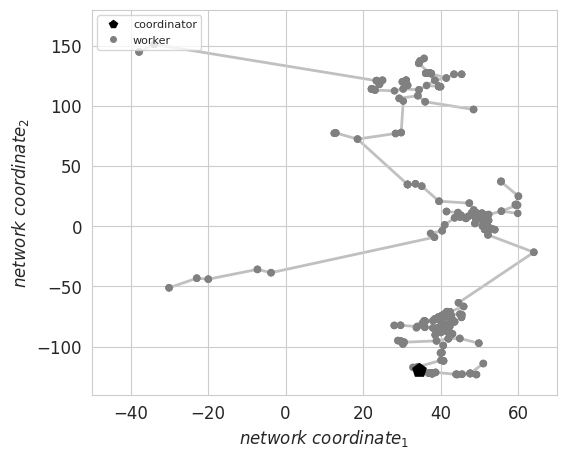

In [105]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/planetlab/mst_planetlab.svg", bbox_inches = "tight")
plt.show()

In [106]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["mst"] = df_stats.copy()

### Experiment 5: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [107]:
# the adjacency matrix for the plane
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)
print(route)

i:0, t(i):10.00, valueNow:19135.0, valueBest:19135.0
i:10, t(i):3.49, valueNow:13358.0, valueBest:13351.0
i:20, t(i):1.22, valueNow:11414.0, valueBest:11413.0
i:30, t(i):0.42, valueNow:9942.0, valueBest:9942.0
i:40, t(i):0.15, valueNow:9591.0, valueBest:9591.0
i:50, t(i):0.05, valueNow:9007.0, valueBest:9007.0
i:60, t(i):0.02, valueNow:8346.0, valueBest:8346.0
[259  89 307 333 424 311 226 425 242 324 251 350  77  75 195 262 232 419
 422 418  47 397  49 400 113 197 387 429 112 110  16 317 190 458 457 202
 156 360 443 417 361 403 404 162 366 292 272 281 305 304 308 385 384 406
 235 283 290 462 344 234 205 160 161 420 233 189 345 207 407 411 131  43
  85  13 468 466 467 183  45  60 228   1 376 414 223 102 364  24 353 347
 330 101 219  23  48 211 210 398 196 268  76 107 391 157 158 326 367 421
 370  17 310 392 224 225 349  96 199 381 455 454 275 451 123 372 309 270
 138 358 130 437 269 260  94  78 388 323  29  30  98 321 135 108  12  11
 359 435  20   7 390 185 441 261  19  55  64 192  73 

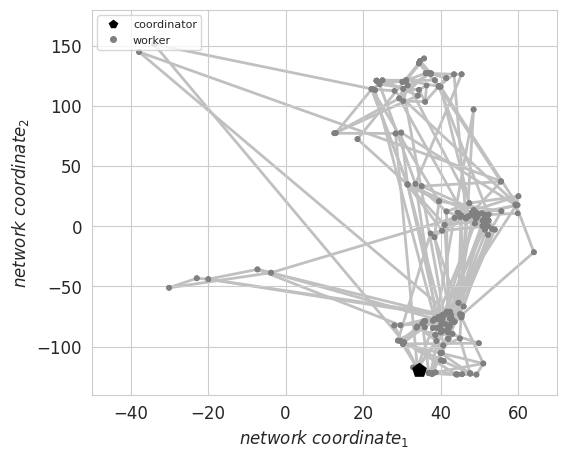

In [108]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/planetlab/chain_50n.svg", bbox_inches="tight")
plt.show()

In [109]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  188  in route.


In [110]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
464    1.0
465    1.0
466    1.0
467    1.0
468    1.0
Name: received_packets, Length: 469, dtype: float64


count     469.000000
mean     2107.388335
std      1341.492869
min         0.000000
25%      1117.431260
50%      2013.266514
75%      3067.704097
max      4805.503330
Name: latency_distribution, dtype: float64
count     469.000000
mean     2107.388335
std      1341.492869
min         0.000000
25%      1117.431260
50%      2013.266514
75%      3067.704097
max      4805.503330
Name: latency_distribution, dtype: float64
count    469.000000
mean       0.997868
std        0.080036
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


(array([0]),)

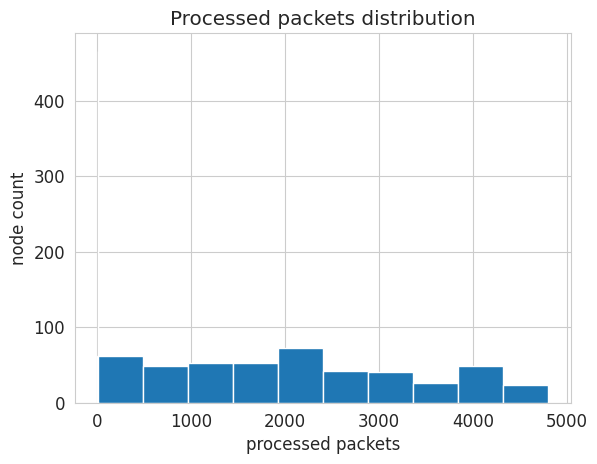

In [111]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())
print(df_stats["latency_distribution"].describe())
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()
np.where(received_packets_hist > 1)

## Evaluation

In [112]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_rc', 'nemo_dc']

color_list = sns.color_palette(n_colors=7)
colors = np.asarray(color_list.as_hex())

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6]
}

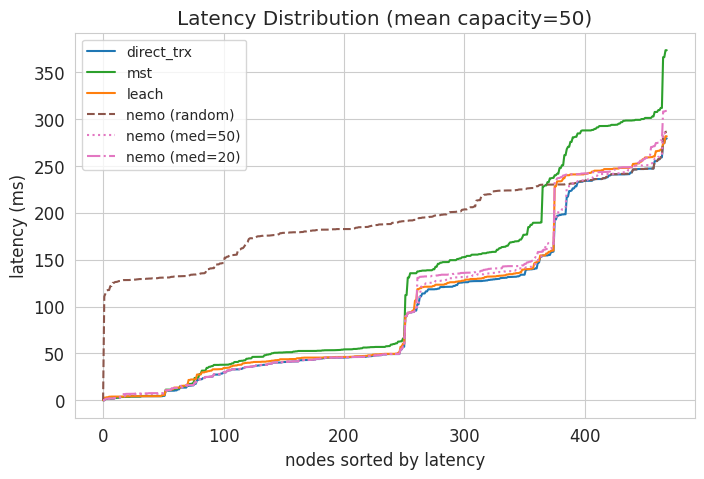

Means:  {'dt': 96.95, 'mst': 120.88, 'leach': 101.37, 'chain': 2107.39, 'nemo (random)': 189.67, 'nemo (med=50)': 99.58, 'nemo (med=20)': 102.97}
Quantiles:  {'dt': 240.08, 'mst': 293.21, 'leach': 246.74, 'chain': 4106.73, 'nemo (random)': 240.36, 'nemo (med=50)': 241.62, 'nemo (med=20)': 244.26}


In [113]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    elif l == "chain":
        continue
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for l in heterogen_appr:
    if l in ["nemo_dc", "nemo_rc"]:
        cl = l
        emat = eval_matrix[l]
        #print("Mean latency ", l, ": ", round(emat["capacity_50"]["latency_distribution"].mean(), 2))

        if l == "nemo_dc":
            l = "nemo"
        elif l == "nemo_rc":
            l = "nemo (random)"

        i = 0
        for k, df in emat.items():
            if l != "nemo" and k != "base":
                continue
            #if i % 50 == 0:
            if l=="nemo" and k == "base":
                continue
                sv = df["latency_distribution"].sort_values()
                sv.plot(ax=ax1, use_index=False, label=l + " (base)", color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "base":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l] = round(sv.quantile(0.9), 2)
                mean_dict[l] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "capacity_100":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ first_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ first_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l+" (med="+ first_med_label + ")", color=eval_colors[cl], linestyle=":")
            elif k == "capacity_1":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ last_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ last_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label= l+" (med="+ last_med_label + ")", color=eval_colors[cl], linestyle="-.")
            i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')
ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
#plt.ylim([0, 150])
plt.savefig("plots/planetlab/eval_latency.svg")
plt.show()

print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

In [114]:
load_dict = {}
nn_dict = {}
for k, df in eval_matrix.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in capacity_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in capacity_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = capacity_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat["base"]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k + "_base"] = capacity_list
        nn_dict[k + "_base"] = nn_list
load_dict.keys()
agg_arr1 = []
for fam in heterogen_appr:
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
mr = np.mean(np.array(agg_arr1), axis=0)
load_dict["NEMO+redistribution"] = mr
print(mr)

agg_arr2 = []
for fam in heterogen_appr:
    agg_arr2.append(load_dict[fam + "_base"])
mr = np.mean(np.array(agg_arr2), axis=0)
load_dict["NEMO_base"] = mr
print(mr)

Fam:  nemo_rc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.  2.5]


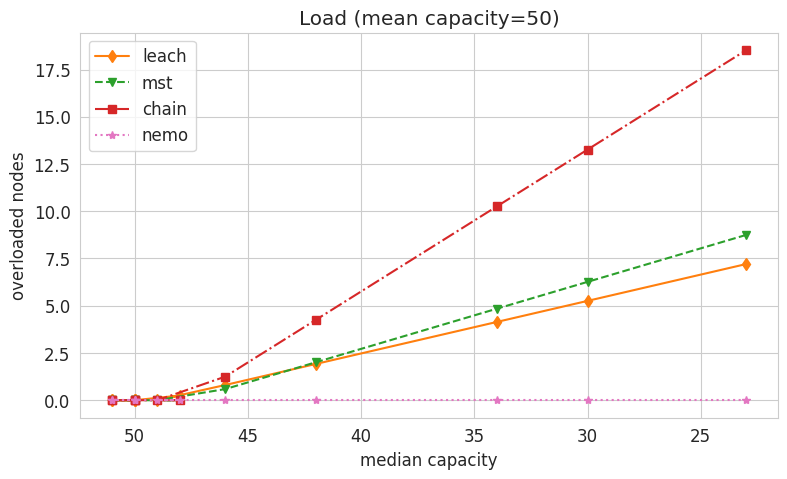

In [115]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in aggregation_fams + ["NEMO+redistribution", "NEMO_base"]:
    vals = load_dict[fam]
    evcol = fam
    m, b = np.polyfit(medians, vals, 1)
    if fam == "sbon":
        fam = "sbon+NEMO_grouping"
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "NEMO+redistribution":
        fam = "nemo"
    if fam == "NEMO_base":
        fam = "nemo (base)"
        continue
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")

#ax.set_yscale('log')
ax.legend()
plt.savefig("plots/planetlab/eval_load.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [116]:
quant_dict

{'dt': 240.08,
 'mst': 293.21,
 'leach': 246.74,
 'chain': 4106.73,
 'nemo (random)': 240.36,
 'nemo (med=50)': 241.62,
 'nemo (med=20)': 244.26}

In [117]:
mean_dict

{'dt': 96.95,
 'mst': 120.88,
 'leach': 101.37,
 'chain': 2107.39,
 'nemo (random)': 189.67,
 'nemo (med=50)': 99.58,
 'nemo (med=20)': 102.97}